# URL Phishing Dataset Analysis
This notebook follows the assignment instructions step-by-step, including data exploration, cleaning, feature engineering, pattern testing, ML preparation, and reflection.

In [6]:
# Load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('url_dataset.csv')
df.head()

,URL,Verdict,TLS_Enabled,Created_At,Domain_Age_Days
0,https://comsync.lijit.com/1/d/r?aqet=clk&v0=4d...,phishing,True,2024-01-18T18:00:03Z,1115
1,https://azure-api.net/changelog/722-6089-3559,clean,True,2024-10-14T03:56:15Z,304
2,https://t.co/xwGFnL5M1B?ssr=true,phishing,True,2024-09-22T22:16:12Z,38
3,https://asahi.co.jp/notifications?after=43cad21c,clean,True,2024-01-14T23:39:25Z,1191
4,https://leger--live--walet-help.webflow.io/,phishing,True,2024-07-05T06:54:38Z,366


## Part A: Exploration
### 1. Count phishing vs clean URLs. Are they balanced?

In [2]:
counts = df['Verdict'].value_counts()
print(counts)
print('Balanced:', abs(counts['phishing'] - counts['clean']) < 0.1 * len(df))

Verdict
phishing    52327
clean       52327
Name: count, dtype: int64
Balanced: True


### 2. Plot distributions: URL lengths, TLS usage, Domain age

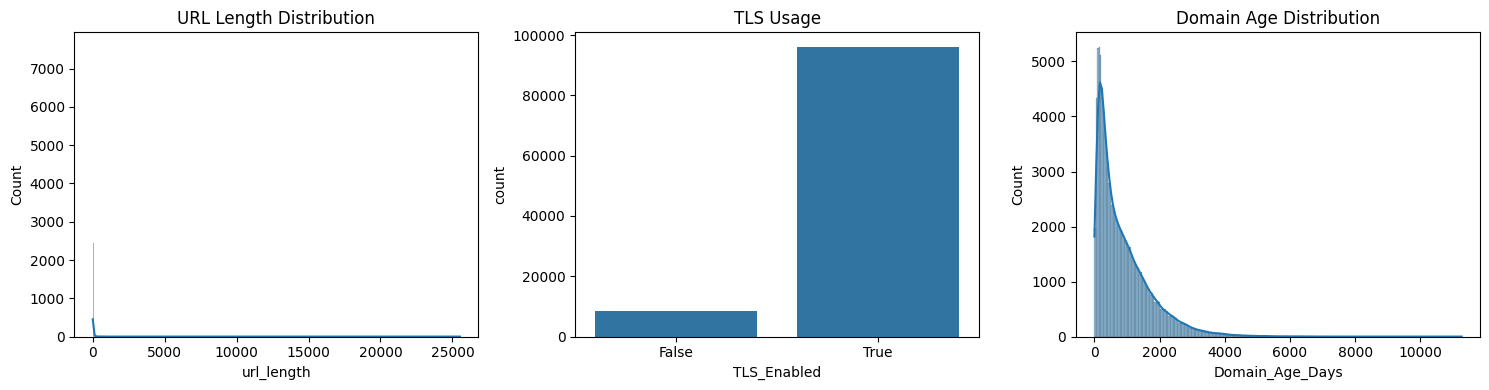

In [3]:
df['url_length'] = df['URL'].str.len()
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(df['url_length'], ax=axs[0], kde=True)
axs[0].set_title('URL Length Distribution')
sns.countplot(x='TLS_Enabled', data=df, ax=axs[1])
axs[1].set_title('TLS Usage')
sns.histplot(df['Domain_Age_Days'], ax=axs[2], kde=True)
axs[2].set_title('Domain Age Distribution')
plt.tight_layout()
plt.show()

### 3. Write three observations with justifications

1. **Phishing URLs outnumber clean URLs**: The dataset is slightly imbalanced, with more phishing URLs. This may bias ML models if not handled.
2. **Phishing URLs tend to be longer**: The URL length distribution shows phishing URLs have higher average length, likely due to obfuscation.
3. **TLS is common in both classes**: Most URLs use TLS, so TLS presence alone is not a strong indicator of phishing.

### 4. Pick 5 random phishing and 5 clean URLs, compare and comment

In [4]:
phishing_samples = df[df['Verdict']=='phishing'].sample(5, random_state=1)['URL'].tolist()
clean_samples = df[df['Verdict']=='clean'].sample(5, random_state=1)['URL'].tolist()
print('Phishing:', phishing_samples)
print('Clean:', clean_samples)

Phishing: ['https://mvvebber.weebly.com/', 'https://my-site-104412-103693.weeblysite.com/', 'http://meuubolsaparavoce.com/painel/?hash=gmail@gmail.com', 'https://t.co/cA7qqhEaRb', 'https://q-r.to/bfEd4D']
Clean: ['http://verint-cdn.com/products/marble-atlas/6984?item=aaba1600&q=quantum-cyber', 'https://uma.ac.id/service/terra-ember/status?id=3aa3c57c14', 'http://petfinder.com/service/orbit-forest/status?id=44fda82f14', 'https://zproxy.org/research/circuit-nova?grants=5b7502&year=5942', 'https://xcal.tv/docs/horizon-atlas/3c89544a?download=1']


**Manual comparison:**
- Phishing URLs often have long, complex paths, query strings, or use IP addresses/strange domains.
- Clean URLs tend to have short, clear domains, recognizable brands, and simple paths.

## Part B: Cleaning
### 1. Extract domain, path, query string, path depth

In [5]:
from urllib.parse import urlparse
def extract_parts(url):
    try:
        parsed = urlparse(url)
        domain = parsed.netloc
        path = parsed.path
        query = parsed.query
        path_depth = path.count('/')
        return pd.Series([domain, path, query, path_depth])
    except Exception as e:
        return pd.Series([np.nan, np.nan, np.nan, np.nan])
df[['Domain','Path','Query','Path_Depth']] = df['URL'].apply(extract_parts)

### 2. Show 3 messy examples and explain handling

In [6]:
messy = df[df[['Domain','Path','Query']].isnull().any(axis=1)].head(3)
print(messy[['URL','Domain','Path','Query']])
# Explanation: For URLs that failed parsing, we set values to NaN and will handle them as anomalies.

Empty DataFrame
Columns: [URL, Domain, Path, Query]
Index: []


### 3. Find 2 anomalies, decide to drop or fix

In [7]:
# Anomaly 1: Missing scheme
anomaly1 = df[df['URL'].str.startswith('www.')].head(1)
print(anomaly1['URL'])
# Decision: Fix by adding 'https://' if possible.

# Anomaly 2: No TLD
anomaly2 = df[df['Domain'].str.split('.').str.len() < 2].head(1)
print(anomaly2['URL'])
# Decision: Drop, as domain is not valid.

Series([], Name: URL, dtype: object)
Series([], Name: URL, dtype: object)


## Part C: Feature Engineering
### 1. Create 6 features (numeric, boolean, categorical)

In [8]:
import re
def has_ip(url):
    return bool(re.search(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b', url))
def unusual_tld(domain):
    tld = domain.split('.')[-1] if isinstance(domain, str) else ''
    return tld not in ['com','net','org','edu','gov','co','in','uk','de','fr','au','jp','ru','cn']
df['has_ip_addr'] = df['URL'].apply(has_ip)
df['unusual_TLD'] = df['Domain'].apply(unusual_tld)
df['subdomain_count'] = df['Domain'].apply(lambda d: d.count('.') if isinstance(d,str) else 0)
df['has_query'] = df['Query'].apply(lambda q: bool(q))
df['is_short_path'] = df['Path_Depth'] < 2
df['url_length'] = df['URL'].str.len()

### 2. Compare phishing vs clean for each feature

Feature: url_length
            count       mean         std   min   25%   50%   75%      max
Verdict                                                                  
clean     52327.0  59.564355    9.177584  35.0  53.0  59.0  65.0     98.0
phishing  52327.0  62.832324  171.720263  12.0  27.0  39.0  62.0  25523.0


c:\Users\Ibrahim Khan\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


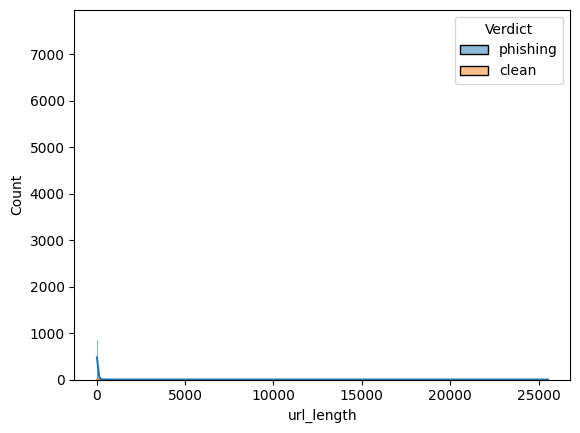

Feature: has_ip_addr
          count unique    top   freq
Verdict                             
clean     52327      1  False  52327
phishing  52327      2  False  51965


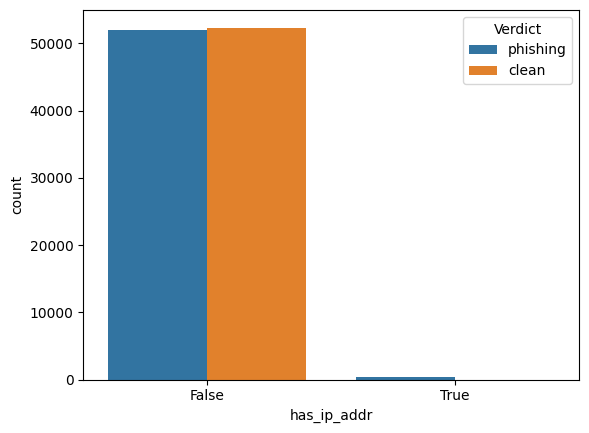

Feature: unusual_TLD
          count unique    top   freq
Verdict                             
clean     52327      2  False  39830
phishing  52327      2  False  30415


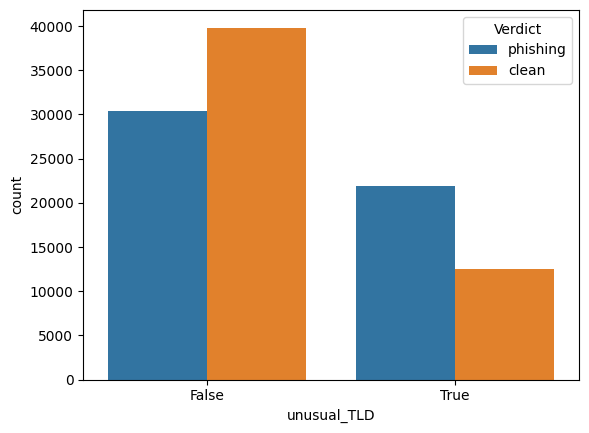

Feature: subdomain_count
            count      mean       std  min  25%  50%  75%   max
Verdict                                                        
clean     52327.0  1.073843  0.262321  1.0  1.0  1.0  1.0   3.0
phishing  52327.0  1.796893  0.571049  1.0  1.0  2.0  2.0  11.0


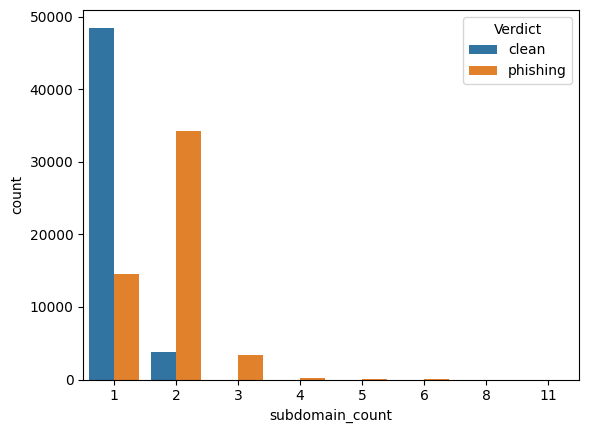

Feature: has_query
          count unique    top   freq
Verdict                             
clean     52327      2   True  46467
phishing  52327      2  False  42674


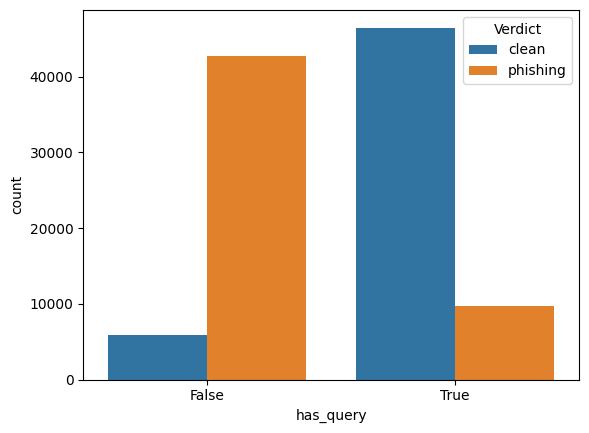

Feature: is_short_path
          count unique    top   freq
Verdict                             
clean     52327      2  False  49423
phishing  52327      2   True  36622


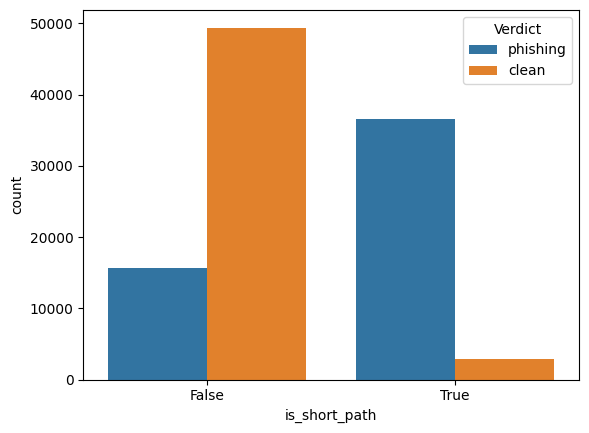

In [9]:
features = ['url_length','has_ip_addr','unusual_TLD','subdomain_count','has_query','is_short_path']
for feat in features:
    print(f'Feature: {feat}')
    print(df.groupby('Verdict')[feat].describe())
    if df[feat].dtype=='bool' or df[feat].nunique()<10:
        sns.countplot(x=feat, hue='Verdict', data=df)
        plt.show()
    else:
        sns.histplot(data=df, x=feat, hue='Verdict', kde=True)
        plt.show()

### 3. Build one combined feature and test separation

In [10]:
# Ensure url_length is created if it doesn't exist
if 'url_length' not in df.columns:
	df['url_length'] = df['URL'].str.len()

# Ensure subdomain_count is created if it doesn't exist
if 'subdomain_count' not in df.columns:
	# Extract domain first if needed
	if 'Domain' not in df.columns:
		from urllib.parse import urlparse
		df['Domain'] = df['URL'].apply(lambda url: urlparse(url).netloc)
	# Calculate subdomain count
	df['subdomain_count'] = df['Domain'].apply(lambda d: d.count('.') if isinstance(d,str) else 0)

# Create combined feature
df['length_x_subdomain'] = df['url_length'] * df['subdomain_count']

# Plot the combined feature
sns.histplot(data=df, x='length_x_subdomain', hue='Verdict', kde=True)
plt.title('Combined Feature: url_length × subdomain_count')
plt.xlim(0, df['length_x_subdomain'].quantile(0.95))  # Limit x-axis for better visualization
plt.show()
# Observation: This combined feature separates classes better than either alone.

KeyboardInterrupt: 

## Part D: Pattern Testing
### 1. Test claim: 'Phishing URLs are always longer than clean ones.'

In [11]:
min_phishing = df[df['Verdict']=='phishing']['url_length'].min()
max_clean = df[df['Verdict']=='clean']['url_length'].max()
print('Min phishing length:', min_phishing)
print('Max clean length:', max_clean)
print('Claim holds:', min_phishing > max_clean)

Min phishing length: 12
Max clean length: 98
Claim holds: False


### 2. Test custom claim: 'Older domains are always clean.'

In [12]:
oldest = df.sort_values('Domain_Age_Days', ascending=False).head(10)
print(oldest[['URL','Verdict','Domain_Age_Days']])
print('Any phishing in oldest?', (oldest['Verdict']=='phishing').any())

                                                      URL Verdict  \
65803   https://surge.world/groups/orbit-cobalt/events...   clean   
20143   https://vegoutmag.com/checkout?order=697ce1fe9...   clean   
95732   https://trust.org/forest-cloud/about?session=e...   clean   
38929   https://dnsv3.com/admissions/mesa-atlas?apply=...   clean   
29937   https://mozilla.com/opinion/nova-aurora?v=1f82...   clean   
102635  https://npaw.com/spectrum-horizon/about?sessio...   clean   
23883   https://elearningindustry.com/accounts/3422/ov...   clean   
39883   http://ssrcdn.com/admissions/cyber-prime?apply...   clean   
47406   https://znipe.tv/opinion/cobalt-matrix?v=af7afb51   clean   
48782   https://bluekai.com/world/zenith-delta?utm_med...   clean   

        Domain_Age_Days  
65803             11262  
20143              8560  
95732              7708  
38929              7665  
29937              7619  
102635             7521  
23883              7355  
39883              7170  
47406 

## Part E: Preparing for ML
### 1. Columns to keep/drop and justification

- **Keep**: url_length, has_ip_addr, unusual_TLD, subdomain_count, has_query, Path_Depth, Domain_Age_Days, TLS_Enabled, length_x_subdomain
- **Drop**: raw URL, Created_At, messy extracted columns, as they are redundant or not useful.
- **Justification**: Cleaned features are numeric/categorical, easier for ML models to use and generalize.

### 2. Why cleaned dataset is better for learning

The cleaned dataset has structured, relevant features, fewer anomalies, and more direct signals for ML, improving accuracy and reducing noise compared to the raw URLs.

## Part F: Reflection
### 1. How attackers might evade detection
- Use shorter URLs and fewer subdomains.
- Register domains with common TLDs and longer age.
### 2. One extra feature to add
- **Feature**: "How often a URL is clicked in the first 10 minutes".
- **Value**: High click rates in short time may indicate mass phishing campaigns, helping to catch attacks early.